# 6 Azure Maps Geospatial Analytics

https://azure.microsoft.com/en-us/products/azure-maps/?msockid=2e39c66c693c66a5151fd200687567d0

https://learn.microsoft.com/en-us/azure/azure-maps/

In [1]:
import folium
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import requests
import seaborn as sns
import sys

from datetime import datetime, timedelta
from dotenv import load_dotenv
from IPython.display import IFrame, FileLink
from math import radians, cos, sin, asin, sqrt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from typing import List, Dict, Tuple, Optional

## Settings

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
load_dotenv("azure.env")

True

In [4]:
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

In [5]:
class AzureMapsClient:
    """
    Azure Maps API Client for Python
    """
    def __init__(self, subscription_key: str):
        """
        Initialize Azure Maps client
        
        Args:
            subscription_key: Your Azure Maps subscription key
        """
        self.subscription_key = subscription_key
        self.base_url = "https://atlas.microsoft.com"

    def _make_request(self, endpoint: str, params: Dict) -> Dict:
        """
        Make authenticated request to Azure Maps API
        
        Args:
            endpoint: API endpoint
            params: Request parameters
            
        Returns:
            API response as dictionary
        """
        params['api-version'] = '1.0'
        params['subscription-key'] = self.subscription_key

        url = f"{self.base_url}/{endpoint}"

        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API request failed: {e}")
            return {}

In [6]:
azure_maps = AzureMapsClient(os.getenv('AZURE_MAPS_KEY'))

## Helper

In [7]:
class GeospatialAnalytics:
    """
    Advanced geospatial analytics using Azure Maps data
    """
    def __init__(self, azure_maps_client):
        self.client = azure_maps_client

    def haversine_distance(self, lat1: float, lon1: float, lat2: float,
                           lon2: float) -> float:
        """
        Calculate the great circle distance between two points on earth in kilometers
        
        Args:
            lat1, lon1: First point coordinates
            lat2, lon2: Second point coordinates
            
        Returns:
            Distance in kilometers
        """
        # Convert decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * asin(sqrt(a))

        # Radius of earth in kilometers
        r = 6371
        return c * r

    def create_distance_matrix(
            self, points: List[Tuple[float, float]]) -> np.ndarray:
        """
        Create distance matrix between all points
        
        Args:
            points: List of (lat, lon) coordinates
            
        Returns:
            Distance matrix as numpy array
        """
        n = len(points)
        matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(n):
                if i != j:
                    matrix[i][j] = self.haversine_distance(
                        points[i][0], points[i][1], points[j][0], points[j][1])

        return matrix

    def spatial_clustering(self,
                           points: List[Tuple[float, float]],
                           eps_km: float = 0.5,
                           min_samples: int = 5) -> List[int]:
        """
        Perform spatial clustering using DBSCAN
        
        Args:
            points: List of coordinate points
            eps_km: Maximum distance between samples in kilometers
            min_samples: Minimum samples in a neighborhood
            
        Returns:
            Cluster labels for each point
        """
        if len(points) < min_samples:
            return [0] * len(points)

        # Convert to array and normalize coordinates
        coords = np.array(points)

        # DBSCAN clustering (eps in degrees, roughly converted from km)
        eps_degrees = eps_km / 111.0  # Rough conversion
        clustering = DBSCAN(eps=eps_degrees,
                            min_samples=min_samples).fit(coords)

        return clustering.labels_.tolist()

    def find_optimal_locations(
            self,
            demand_points: List[Tuple[float, float, float]],
            num_facilities: int = 3) -> List[Tuple[float, float]]:
        """
        Find optimal facility locations using K-means clustering
        
        Args:
            demand_points: List of (lat, lon, demand_weight) tuples
            num_facilities: Number of facilities to locate
            
        Returns:
            List of optimal facility coordinates
        """
        # Extract coordinates and weights
        coords = np.array([(p[0], p[1]) for p in demand_points])
        weights = np.array([p[2] for p in demand_points])

        # Weighted K-means clustering
        kmeans = KMeans(n_clusters=num_facilities, random_state=42)

        # Repeat points based on weights for weighted clustering
        weighted_coords = []
        for i, (coord, weight) in enumerate(zip(coords, weights)):
            repetitions = max(1, int(weight * 10))  # Scale weights
            weighted_coords.extend([coord] * repetitions)

        weighted_coords = np.array(weighted_coords)
        kmeans.fit(weighted_coords)

        return [tuple(center) for center in kmeans.cluster_centers_]

    def calculate_service_area(self, center: Tuple[float, float],
                               radius_km: float) -> List[Tuple[float, float]]:
        """
        Calculate approximate circular service area
        
        Args:
            center: Center coordinates
            radius_km: Service radius in kilometers
            
        Returns:
            List of coordinates forming service area boundary
        """
        lat_center, lon_center = center

        # Convert radius to degrees (rough approximation)
        radius_deg = radius_km / 111.0

        # Generate circle points
        circle_points = []
        for angle in range(0, 360, 10):  # Every 10 degrees
            angle_rad = radians(angle)
            lat = lat_center + radius_deg * cos(angle_rad)
            lon = lon_center + radius_deg * sin(angle_rad) / cos(
                radians(lat_center))
            circle_points.append((lat, lon))

        # Close the circle
        circle_points.append(circle_points[0])

        return circle_points

## Examples

In [8]:
analytics = GeospatialAnalytics(azure_maps)

### Example 1: Generate Sample Business Data

In [9]:
def generate_business_data(city_center: Tuple[float, float],
                           num_businesses: int = 100) -> List[Dict]:
    """Generate sample business data for analysis"""
    businesses = []
    business_types = [
        'restaurant', 'retail', 'service', 'entertainment', 'healthcare',
        'education', 'office', 'manufacturing'
    ]

    lat_center, lon_center = city_center

    for i in range(num_businesses):
        # Random location within city bounds
        lat = lat_center + random.gauss(0, 0.02)  # ~2km spread
        lon = lon_center + random.gauss(0, 0.02)

        # Random business properties
        business = {
            'id': f'BUS_{i+1:03d}',
            'name': f'Business {i+1}',
            'type': random.choice(business_types),
            'lat': lat,
            'lon': lon,
            'employees': random.randint(5, 500),
            'revenue': random.randint(100000, 10000000),
            'rating': round(random.uniform(3.0, 5.0), 1),
            'established': random.randint(1990, 2023)
        }

        businesses.append(business)

    return businesses


# Generate sample data for Seattle
seattle_center = (47.6062, -122.3321)
sample_businesses = generate_business_data(seattle_center, 150)

print(f"Generated {len(sample_businesses)} sample businesses")
print("Sample business types distribution:")

business_df = pd.DataFrame(sample_businesses)
type_counts = business_df['type'].value_counts()
for btype, count in type_counts.items():
    print(f"  {btype.title()}: {count}")

Generated 150 sample businesses
Sample business types distribution:
  Retail: 24
  Manufacturing: 23
  Service: 22
  Education: 18
  Restaurant: 18
  Entertainment: 17
  Office: 16
  Healthcare: 12


### Example 2: Spatial Clustering Analysis

In [10]:
# Extract coordinates for clustering
business_coords = [(b['lat'], b['lon']) for b in sample_businesses]

# Perform spatial clustering
cluster_labels = analytics.spatial_clustering(business_coords,
                                              eps_km=1.0,
                                              min_samples=5)

# Add cluster labels to business data
for i, business in enumerate(sample_businesses):
    business['cluster'] = cluster_labels[i]

# Analyze clusters
cluster_analysis = {}
for label in set(cluster_labels):
    if label != -1:  # Exclude noise points
        cluster_businesses = [
            b for b in sample_businesses if b['cluster'] == label
        ]

        cluster_analysis[label] = {
            'count':
            len(cluster_businesses),
            'avg_employees':
            np.mean([b['employees'] for b in cluster_businesses]),
            'avg_revenue':
            np.mean([b['revenue'] for b in cluster_businesses]),
            'dominant_type':
            pd.Series([b['type'] for b in cluster_businesses]).mode()[0]
        }

print("Business Cluster Analysis:")
for cluster_id, stats in cluster_analysis.items():
    print(f"\nCluster {cluster_id}:")
    print(f"  Businesses: {stats['count']}")
    print(f"  Avg Employees: {stats['avg_employees']:.0f}")
    print(f"  Avg Revenue: ${stats['avg_revenue']:,.0f}")
    print(f"  Dominant Type: {stats['dominant_type'].title()}")

Business Cluster Analysis:

Cluster 0:
  Businesses: 122
  Avg Employees: 273
  Avg Revenue: $5,042,950
  Dominant Type: Manufacturing

Cluster 1:
  Businesses: 10
  Avg Employees: 243
  Avg Revenue: $5,965,709
  Dominant Type: Office


### Example 3: Market Analysis

In [11]:
# Analyze market density and competition
def analyze_market_density(businesses: List[Dict],
                           analysis_radius: float = 2.0) -> Dict:
    """Analyze business density and competition"""

    analysis_results = []

    for business in businesses:
        # Find competitors within radius
        competitors = []
        for other in businesses:
            if other['id'] != business['id']:
                distance = analytics.haversine_distance(
                    business['lat'], business['lon'], other['lat'],
                    other['lon'])

                if distance <= analysis_radius:
                    competitors.append({
                        'distance': distance,
                        'type': other['type'],
                        'employees': other['employees'],
                        'revenue': other['revenue']
                    })

        # Calculate competition metrics
        same_type_competitors = [
            c for c in competitors if c['type'] == business['type']
        ]
        total_nearby_revenue = sum(c['revenue'] for c in competitors)

        analysis_results.append({
            'business_id':
            business['id'],
            'nearby_businesses':
            len(competitors),
            'same_type_competitors':
            len(same_type_competitors),
            'competition_intensity':
            len(same_type_competitors) / max(1, len(competitors)),
            'market_revenue':
            total_nearby_revenue,
            'avg_competitor_distance':
            np.mean([c['distance'] for c in competitors]) if competitors else 0
        })

    return analysis_results


market_analysis = analyze_market_density(sample_businesses)

# Create market analysis summary
market_df = pd.DataFrame(market_analysis)
print("Market Analysis Summary:")
print(
    f"  Average nearby businesses: {market_df['nearby_businesses'].mean():.1f}"
)
print(
    f"  Average competition intensity: {market_df['competition_intensity'].mean():.2f}"
)
print(f"  Average market revenue: ${market_df['market_revenue'].mean():,.0f}")

# Find highest competition areas
high_competition = market_df.nlargest(5, 'competition_intensity')
print("\nHighest Competition Areas:")

for _, row in high_competition.iterrows():
    print(f"  Business {row['business_id']}: {row['competition_intensity']:.2f} intensity")

Market Analysis Summary:
  Average nearby businesses: 37.9
  Average competition intensity: 0.12
  Average market revenue: $186,787,865

Highest Competition Areas:
  Business BUS_037: 0.50 intensity
  Business BUS_106: 0.40 intensity
  Business BUS_051: 0.35 intensity
  Business BUS_049: 0.30 intensity
  Business BUS_099: 0.28 intensity


### Example 4: Optimal Location Analysis

In [12]:
# Create demand points (customers) based on population density
def generate_demand_points(
        center: Tuple[float, float],
        num_points: int = 200) -> List[Tuple[float, float, float]]:
    """Generate customer demand points with varying weights"""
    demand_points = []
    lat_center, lon_center = center

    # Create demand clusters (residential areas, shopping districts, etc.)
    demand_clusters = [
        (lat_center + 0.01, lon_center - 0.01, 100),  # Downtown
        (lat_center - 0.015, lon_center + 0.02, 80),  # Suburbs
        (lat_center + 0.025, lon_center + 0.015, 60),  # Business district
        (lat_center - 0.008, lon_center - 0.025, 90),  # Residential area
    ]

    for _ in range(num_points):
        # Choose cluster based on weights
        cluster_weights = [c[2] for c in demand_clusters]
        cluster = random.choices(demand_clusters, weights=cluster_weights)[0]

        # Add variation around cluster center
        lat = cluster[0] + random.gauss(0, 0.005)
        lon = cluster[1] + random.gauss(0, 0.005)
        demand = random.uniform(0.5, 2.0)  # Demand weight

        demand_points.append((lat, lon, demand))

    return demand_points


# Generate customer demand data
customer_demand = generate_demand_points(seattle_center, 300)

# Find optimal locations for new facilities (e.g., distribution centers)
optimal_locations = analytics.find_optimal_locations(customer_demand,
                                                     num_facilities=4)

print(f"Optimal facility locations for {len(customer_demand)} demand points:")
for i, (lat, lon) in enumerate(optimal_locations):
    print(f"  Facility {i+1}: {lat:.4f}, {lon:.4f}")

# Calculate service areas
service_areas = []
for i, location in enumerate(optimal_locations):
    area_boundary = analytics.calculate_service_area(location, radius_km=3.0)
    service_areas.append(area_boundary)

print(f"Generated service areas with 3km radius for each facility")

Optimal facility locations for 300 demand points:
  Facility 1: 47.6163, -122.3416
  Facility 2: 47.5911, -122.3128
  Facility 3: 47.5979, -122.3568
  Facility 4: 47.6317, -122.3176
Generated service areas with 3km radius for each facility


### Example 5: Distance Matrix Analysis

In [13]:
print("\n5. Distance Matrix and Accessibility Analysis")
print("-" * 43)

# Select key locations for accessibility analysis
key_locations = optimal_locations + [seattle_center]
location_names = [f"Facility {i+1}"
                  for i in range(len(optimal_locations))] + ["City Center"]

# Create distance matrix
distance_matrix = analytics.create_distance_matrix(key_locations)

print("Distance Matrix (km):")
print("From/To\t\t", end="")
for name in location_names:
    print(f"{name[:10]:<12}", end="")
print()

for i, from_name in enumerate(location_names):
    print(f"{from_name:<15}", end="")
    for j, to_name in enumerate(location_names):
        distance = distance_matrix[i][j]
        if distance == 0:
            print(f"{'---':<12}", end="")
        else:
            print(f"{distance:<12.1f}", end="")
    print()

# Find accessibility metrics
avg_distances = np.mean(distance_matrix, axis=1)
print(f"\nAccessibility Analysis:")
for i, (name, avg_dist) in enumerate(zip(location_names, avg_distances)):
    print(f"  {name}: Average distance to other locations: {avg_dist:.1f} km")


5. Distance Matrix and Accessibility Analysis
-------------------------------------------
Distance Matrix (km):
From/To		Facility 1  Facility 2  Facility 3  Facility 4  City Cente  
Facility 1     ---         3.5         2.3         2.5         1.3         
Facility 2     3.5         ---         3.4         4.5         2.2         
Facility 3     2.3         3.4         ---         4.8         2.1         
Facility 4     2.5         4.5         4.8         ---         3.0         
City Center    1.3         2.2         2.1         3.0         ---         

Accessibility Analysis:
  Facility 1: Average distance to other locations: 1.9 km
  Facility 2: Average distance to other locations: 2.7 km
  Facility 3: Average distance to other locations: 2.5 km
  Facility 4: Average distance to other locations: 3.0 km
  City Center: Average distance to other locations: 1.7 km


### Example 6: Business Intelligence Visualization

In [14]:
def create_geospatial_dashboard(
        businesses: List[Dict], clusters: Dict,
        optimal_locs: List[Tuple[float, float]]) -> folium.Map:
    """Create comprehensive geospatial business intelligence map"""

    # Calculate map center
    lats = [b['lat'] for b in businesses]
    lons = [b['lon'] for b in businesses]
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)

    # Create map
    m = folium.Map(location=[center_lat, center_lon],
                   zoom_start=11,
                   tiles='CartoDB positron')

    # Color scheme for business types
    type_colors = {
        'restaurant': '#E74C3C',
        'retail': '#3498DB',
        'service': '#2ECC71',
        'entertainment': '#9B59B6',
        'healthcare': '#E67E22',
        'education': '#F1C40F',
        'office': '#34495E',
        'manufacturing': '#95A5A6'
    }

    # Add business markers with clustering information
    for business in businesses:
        color = type_colors.get(business['type'], '#7F8C8D')
        cluster_id = business.get('cluster', -1)

        # Create popup with business details
        popup_html = f"""
        <div style="font-family: Arial; width: 250px;">
            <h4 style="color: {color}; margin-bottom: 8px;">{business['name']}</h4>
            <table style="width: 100%; font-size: 12px;">
                <tr><td><b>Type:</b></td><td>{business['type'].title()}</td></tr>
                <tr><td><b>Employees:</b></td><td>{business['employees']}</td></tr>
                <tr><td><b>Revenue:</b></td><td>${business['revenue']:,}</td></tr>
                <tr><td><b>Rating:</b></td><td>{'⭐' * int(business['rating'])}</td></tr>
                <tr><td><b>Established:</b></td><td>{business['established']}</td></tr>
                <tr><td><b>Cluster:</b></td><td>{cluster_id if cluster_id != -1 else 'Outlier'}</td></tr>
            </table>
        </div>
        """

        # Marker size based on revenue
        radius = max(5, min(15, business['revenue'] / 500000))

        folium.CircleMarker(location=[business['lat'], business['lon']],
                            popup=folium.Popup(popup_html, max_width=300),
                            tooltip=f"{business['name']} ({business['type']})",
                            radius=radius,
                            color='white',
                            weight=1,
                            fillColor=color,
                            fillOpacity=0.7).add_to(m)

    # Add optimal facility locations
    for i, (lat, lon) in enumerate(optimal_locs):
        folium.Marker(
            location=[lat, lon],
            popup=
            f"<b>Optimal Facility {i+1}</b><br>Recommended location for new facility",
            tooltip=f"Facility {i+1}",
            icon=folium.Icon(color='green', icon='warehouse',
                             prefix='fa')).add_to(m)

        # Add service area circles
        folium.Circle(
            location=[lat, lon],
            radius=3000,  # 3km radius
            popup=f"Service Area {i+1}",
            color='green',
            weight=2,
            fillColor='green',
            fillOpacity=0.1).add_to(m)

    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 300px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px;">
    <h4>Business Intelligence Map</h4>
    <h5>Business Types:</h5>
    '''

    for btype, color in type_colors.items():
        legend_html += f'<p><span style="color:{color};">●</span> {btype.title()}</p>'

    legend_html += '''
    <h5>Symbols:</h5>
    <p><i class="fa fa-warehouse" style="color:green"></i> Optimal Facilities</p>
    <p><span style="color:green;">○</span> Service Areas (3km)</p>
    <p style="font-size:10px;">Marker size = Revenue</p>
    </div>
    '''

    m.get_root().html.add_child(folium.Element(legend_html))

    return m


# Create comprehensive business intelligence map

bi_map = create_geospatial_dashboard(sample_businesses, cluster_analysis,
                                     optimal_locations)
output_file = os.path.join(RESULTS_DIR,
                           "geospatial_business_intelligence.html")
bi_map.save(output_file)
print(f"✅ Map saved as {output_file}")

✅ Map saved as results/geospatial_business_intelligence.html


In [15]:
IFrame(src=output_file, width=860, height=640)

In [16]:
map_link = FileLink(path=output_file)
map_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/azure maps/results/geospatial_business_intelligence.html

### Example 7: Advanced Analytics Charts

Available columns in business_df:
['id', 'name', 'type', 'lat', 'lon', 'employees', 'revenue', 'rating', 'established']
DataFrame shape: (150, 9)
Creating cluster column using DBSCAN clustering...
Created 15 clusters (including outliers)


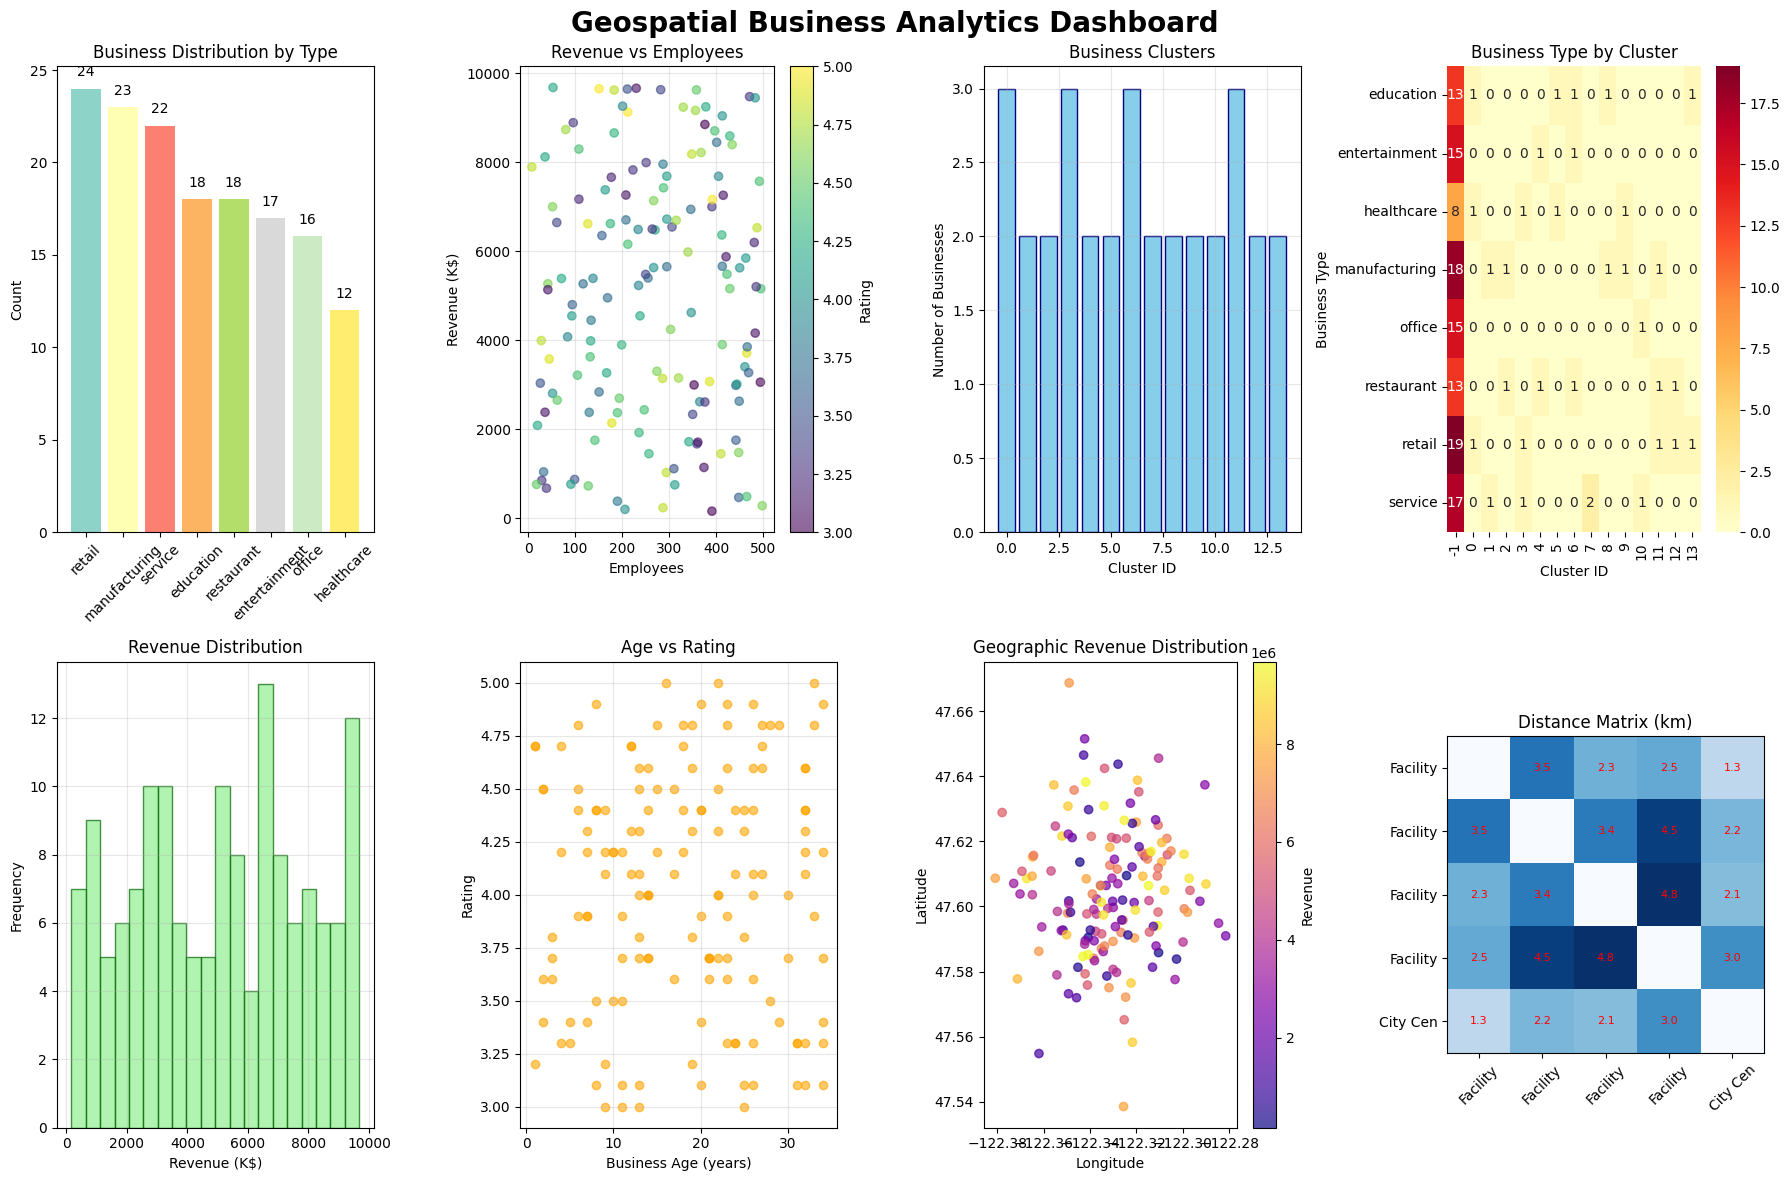


📊 Dashboard Summary:
Total businesses analyzed: 150
Number of clusters: 15
Business types: 8
Available data columns: id, name, type, lat, lon, employees, revenue, rating, established, cluster, age


In [17]:
# First, let's check what columns exist in business_df
print("Available columns in business_df:")
print(business_df.columns.tolist())
print(f"DataFrame shape: {business_df.shape}")

# Ensure we have the necessary columns - create sample cluster data if missing
if 'cluster' not in business_df.columns:
    print("Creating cluster column using DBSCAN clustering...")
    
    # Prepare features for clustering (using lat, lon, and revenue if available)
    cluster_features = []
    feature_names = []
    
    if 'lat' in business_df.columns and 'lon' in business_df.columns:
        cluster_features.extend([business_df['lat'].values, business_df['lon'].values])
        feature_names.extend(['lat', 'lon'])
    
    if 'revenue' in business_df.columns:
        cluster_features.append(business_df['revenue'].values)
        feature_names.append('revenue')
    
    if 'employees' in business_df.columns:
        cluster_features.append(business_df['employees'].values)
        feature_names.append('employees')
    
    if cluster_features:
        # Combine features for clustering
        X = np.column_stack(cluster_features)
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Perform DBSCAN clustering
        clustering = DBSCAN(eps=0.5, min_samples=2)
        cluster_labels = clustering.fit_predict(X_scaled)
        
        # Add cluster labels to dataframe
        business_df['cluster'] = cluster_labels
        print(f"Created {len(set(cluster_labels))} clusters (including outliers)")
    else:
        # Create random clusters if no suitable features found
        print("No suitable features found for clustering, creating random clusters...")
        business_df['cluster'] = np.random.randint(0, 3, size=len(business_df))

# Create comprehensive analytics dashboard
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Geospatial Business Analytics Dashboard', fontsize=20, fontweight='bold')

# Chart 1: Business distribution by type
ax1 = plt.subplot(2, 4, 1)
if 'type' in business_df.columns:
    type_counts = business_df['type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
    bars = ax1.bar(range(len(type_counts)), type_counts.values, color=colors)
    ax1.set_title('Business Distribution by Type')
    ax1.set_ylabel('Count')
    ax1.set_xticks(range(len(type_counts)))
    ax1.set_xticklabels(type_counts.index, rotation=45)
    # Add value labels
    for bar, count in zip(bars, type_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 str(count), ha='center', va='bottom')
else:
    ax1.text(0.5, 0.5, 'No "type" column found', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Business Distribution by Type')

# Chart 2: Revenue vs Employees scatter plot
ax2 = plt.subplot(2, 4, 2)
if 'employees' in business_df.columns and 'revenue' in business_df.columns:
    # Handle missing rating column
    if 'rating' in business_df.columns:
        scatter = ax2.scatter(business_df['employees'], business_df['revenue']/1000, 
                             c=business_df['rating'], cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, ax=ax2, label='Rating')
    else:
        ax2.scatter(business_df['employees'], business_df['revenue']/1000, alpha=0.6)
    ax2.set_xlabel('Employees')
    ax2.set_ylabel('Revenue (K$)')
    ax2.set_title('Revenue vs Employees')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Missing revenue/employees data', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Revenue vs Employees')

# Chart 3: Cluster analysis
ax3 = plt.subplot(2, 4, 3)
cluster_counts = pd.Series(business_df['cluster']).value_counts().sort_index()
cluster_counts = cluster_counts[cluster_counts.index != -1]  # Remove outliers if any
if len(cluster_counts) > 0:
    ax3.bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='navy')
    ax3.set_title('Business Clusters')
    ax3.set_xlabel('Cluster ID')
    ax3.set_ylabel('Number of Businesses')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No valid clusters found', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Business Clusters')

# Chart 4: Market competition heatmap
ax4 = plt.subplot(2, 4, 4)
if 'type' in business_df.columns and 'cluster' in business_df.columns:
    try:
        market_pivot = business_df.groupby(['type', 'cluster']).size().unstack(fill_value=0)
        if not market_pivot.empty:
            sns.heatmap(market_pivot, annot=True, fmt='d', cmap='YlOrRd', ax=ax4)
            ax4.set_title('Business Type by Cluster')
            ax4.set_xlabel('Cluster ID')
            ax4.set_ylabel('Business Type')
        else:
            ax4.text(0.5, 0.5, 'No data for heatmap', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Business Type by Cluster')
    except Exception as e:
        ax4.text(0.5, 0.5, f'Heatmap error: {str(e)[:30]}...', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Business Type by Cluster')
else:
    ax4.text(0.5, 0.5, 'Missing type/cluster data', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Business Type by Cluster')

# Chart 5: Revenue distribution
ax5 = plt.subplot(2, 4, 5)
if 'revenue' in business_df.columns:
    ax5.hist(business_df['revenue']/1000, bins=20, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
    ax5.set_title('Revenue Distribution')
    ax5.set_xlabel('Revenue (K$)')
    ax5.set_ylabel('Frequency')
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No revenue data', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Revenue Distribution')

# Chart 6: Age vs Rating correlation
ax6 = plt.subplot(2, 4, 6)
if 'established' in business_df.columns:
    business_df['age'] = 2024 - business_df['established']
    if 'rating' in business_df.columns:
        ax6.scatter(business_df['age'], business_df['rating'], alpha=0.6, color='orange')
        ax6.set_ylabel('Rating')
    else:
        # Plot age distribution if no rating
        ax6.hist(business_df['age'], bins=15, alpha=0.6, color='orange')
        ax6.set_ylabel('Frequency')
    ax6.set_xlabel('Business Age (years)')
    ax6.set_title('Age vs Rating' if 'rating' in business_df.columns else 'Age Distribution')
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No establishment data', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Age vs Rating')

# Chart 7: Geographic distribution
ax7 = plt.subplot(2, 4, 7)
if 'lon' in business_df.columns and 'lat' in business_df.columns:
    if 'revenue' in business_df.columns:
        scatter = ax7.scatter(business_df['lon'], business_df['lat'], 
                             c=business_df['revenue'], cmap='plasma', alpha=0.7)
        plt.colorbar(scatter, ax=ax7, label='Revenue')
    else:
        ax7.scatter(business_df['lon'], business_df['lat'], alpha=0.7)
    ax7.set_xlabel('Longitude')
    ax7.set_ylabel('Latitude')
    ax7.set_title('Geographic Revenue Distribution')
else:
    ax7.text(0.5, 0.5, 'No location data', ha='center', va='center', transform=ax7.transAxes)
    ax7.set_title('Geographic Distribution')

# Chart 8: Distance matrix heatmap (simplified)
ax8 = plt.subplot(2, 4, 8)
try:
    # Check if distance_matrix and location_names exist
    if 'distance_matrix' in locals() and 'location_names' in locals() and distance_matrix.size > 0:
        im = ax8.imshow(distance_matrix, cmap='Blues')
        ax8.set_title('Distance Matrix (km)')
        ax8.set_xticks(range(len(location_names)))
        ax8.set_yticks(range(len(location_names)))
        ax8.set_xticklabels([name[:8] for name in location_names], rotation=45)
        ax8.set_yticklabels([name[:8] for name in location_names])
        
        # Add text annotations
        for i in range(len(location_names)):
            for j in range(len(location_names)):
                if distance_matrix[i, j] > 0:
                    ax8.text(j, i, f'{distance_matrix[i, j]:.1f}', 
                            ha='center', va='center', color='red', fontsize=8)
    else:
        # Create a simple correlation matrix instead
        numeric_cols = business_df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 1:
            corr_matrix = business_df[numeric_cols].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax8)
            ax8.set_title('Correlation Matrix')
        else:
            ax8.text(0.5, 0.5, 'No distance matrix\navailable', ha='center', va='center', transform=ax8.transAxes)
            ax8.set_title('Distance Matrix')
except Exception as e:
    ax8.text(0.5, 0.5, f'Matrix error:\n{str(e)[:20]}...', ha='center', va='center', transform=ax8.transAxes)
    ax8.set_title('Distance Matrix')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Dashboard Summary:")
print(f"Total businesses analyzed: {len(business_df)}")
if 'cluster' in business_df.columns:
    print(f"Number of clusters: {len(business_df['cluster'].unique())}")
if 'type' in business_df.columns:
    print(f"Business types: {len(business_df['type'].unique())}")
print(f"Available data columns: {', '.join(business_df.columns)}")

### Example 8: Predictive Analytics

In [18]:
def predict_business_success(businesses: List[Dict]) -> List[Dict]:
    """Simple predictive model for business success"""
    
    predictions = []
    
    for business in businesses:
        # Simple scoring model based on various factors
        age = 2024 - business['established']
        
        # Age factor (sweet spot around 10-15 years)
        age_score = max(0, 100 - abs(age - 12) * 3)
        
        # Rating factor
        rating_score = business['rating'] * 20
        
        # Employee size factor (economies of scale)
        emp_score = min(100, business['employees'] / 5)
        
        # Cluster factor (being in a cluster is generally good)
        cluster_score = 20 if business['cluster'] != -1 else 0
        
        # Calculate final success score
        success_score = (age_score + rating_score + emp_score + cluster_score) / 4
        
        # Predict growth potential
        if success_score > 80:
            growth_potential = "High"
        elif success_score > 60:
            growth_potential = "Medium"
        else:
            growth_potential = "Low"
        
        predictions.append({
            'business_id': business['id'],
            'name': business['name'],
            'success_score': success_score,
            'growth_potential': growth_potential,
            'age_score': age_score,
            'rating_score': rating_score,
            'emp_score': emp_score,
            'cluster_score': cluster_score
        })
    
    return predictions

# Generate predictions
business_predictions = predict_business_success(sample_businesses)

# Analyze predictions
predictions_df = pd.DataFrame(business_predictions)
print("Predictive Analytics Summary:")
print(f"  High Growth Potential: {len(predictions_df[predictions_df['growth_potential'] == 'High'])} businesses")
print(f"  Medium Growth Potential: {len(predictions_df[predictions_df['growth_potential'] == 'Medium'])} businesses") 
print(f"  Low Growth Potential: {len(predictions_df[predictions_df['growth_potential'] == 'Low'])} businesses")

# Top performing businesses
top_performers = predictions_df.nlargest(10, 'success_score')
print(f"\nTop 10 Highest Scoring Businesses:")
for _, row in top_performers.iterrows():
    print(f"  {row['name']}: Score {row['success_score']:.1f} ({row['growth_potential']} potential)")

Predictive Analytics Summary:
  High Growth Potential: 0 businesses
  Medium Growth Potential: 52 businesses
  Low Growth Potential: 98 businesses

Top 10 Highest Scoring Businesses:
  Business 58: Score 75.2 (Medium potential)
  Business 29: Score 73.0 (Medium potential)
  Business 136: Score 72.7 (Medium potential)
  Business 113: Score 72.2 (Medium potential)
  Business 135: Score 71.9 (Medium potential)
  Business 5: Score 71.4 (Medium potential)
  Business 70: Score 70.1 (Medium potential)
  Business 26: Score 69.5 (Medium potential)
  Business 134: Score 69.4 (Medium potential)
  Business 64: Score 69.2 (Medium potential)


### Example 9: Export Analysis Results

In [19]:
# Compile comprehensive analysis results
analysis_summary = {
    'total_businesses': len(sample_businesses),
    'business_types': dict(business_df['type'].value_counts()),
    'clusters_found': len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0),
    'optimal_facilities': len(optimal_locations),
    'avg_revenue': business_df['revenue'].mean(),
    'avg_employees': business_df['employees'].mean(),
    'avg_rating': business_df['rating'].mean(),
    'high_growth_businesses': len(predictions_df[predictions_df['growth_potential'] == 'High'])
}

# Save detailed results to CSV files
business_df_extended = business_df.copy()
for i, pred in enumerate(business_predictions):
    business_df_extended.loc[i, 'success_score'] = pred['success_score']
    business_df_extended.loc[i, 'growth_potential'] = pred['growth_potential']

output_file = os.path.join(RESULTS_DIR, "business_analysis_results.csv")
business_df_extended.to_csv(output_file, index=False)
print(f"✅ Detailed business analysis saved as {output_file}")

# Save market analysis
output_file = os.path.join(RESULTS_DIR, "market_analysis_results.csv")
market_df.to_csv(output_file, index=False)
print(f"✅ Market analysis saved as {output_file}")

# Save optimal locations
optimal_locations_df = pd.DataFrame(optimal_locations, columns=['latitude', 'longitude'])
optimal_locations_df['facility_id'] = range(1, len(optimal_locations) + 1)
output_file = os.path.join(RESULTS_DIR, "optimal_facility_locations.csv")
optimal_locations_df.to_csv(output_file, index=False)
print(f"✅ Optimal locations saved as {output_file}")

# Save analysis summary as JSON
output_file = os.path.join(RESULTS_DIR, "analysis_summary.json")
with open(output_file, 'w') as f:
    json.dump(analysis_summary, f, indent=2, default=str)
print(f"✅ Analysis summary saved as {output_file}")

✅ Detailed business analysis saved as results/business_analysis_results.csv
✅ Market analysis saved as results/market_analysis_results.csv
✅ Optimal locations saved as results/optimal_facility_locations.csv
✅ Analysis summary saved as results/analysis_summary.json


In [20]:
business_df_extended

,id,name,type,lat,lon,employees,revenue,rating,established,cluster,age,success_score,growth_potential
0,BUS_001,Business 1,education,47.602283,-122.337196,167,3271450,4.2,2015,0,9,57.10,Low
1,BUS_002,Business 2,retail,47.587062,-122.335151,391,7005220,3.3,1993,-1,31,51.80,Low
2,BUS_003,Business 3,office,47.612135,-122.321909,442,1758212,3.6,2022,-1,2,62.60,Medium
3,BUS_004,Business 4,service,47.584633,-122.343109,151,9654912,5.0,2008,-1,16,59.55,Low
4,BUS_005,Business 5,education,47.621529,-122.339496,463,5851005,4.1,2015,-1,9,71.40,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,BUS_146,Business 146,restaurant,47.604933,-122.296920,71,5392023,4.2,2020,-1,4,48.55,Low
146,BUS_147,Business 147,restaurant,47.572151,-122.324676,108,7173448,3.2,2023,-1,1,43.15,Low
147,BUS_148,Business 148,restaurant,47.587870,-122.311554,449,2634514,3.7,2003,-1,21,64.20,Medium
148,BUS_149,Business 149,restaurant,47.606994,-122.328075,494,3061260,3.0,2013,-1,11,68.95,Medium


In [21]:
market_df

,business_id,nearby_businesses,same_type_competitors,competition_intensity,market_revenue,avg_competitor_distance
0,BUS_001,55,4,0.072727,250519719,1.163674
1,BUS_002,59,7,0.118644,253749716,1.235619
2,BUS_003,55,3,0.054545,304444613,1.239226
3,BUS_004,49,6,0.122449,216431178,1.230994
4,BUS_005,37,2,0.054054,188280438,1.416231
...,...,...,...,...,...,...
145,BUS_146,30,2,0.066667,191135798,1.414264
146,BUS_147,23,5,0.217391,111811966,1.473591
147,BUS_148,32,2,0.062500,145897287,1.331924
148,BUS_149,62,4,0.064516,314812750,1.288174


In [22]:
optimal_locations_df

,latitude,longitude,facility_id
0,47.616251,-122.341556,1
1,47.591076,-122.312818,2
2,47.597889,-122.356834,3
3,47.631697,-122.317557,4


In [23]:
analysis_summary

{'total_businesses': 150,
 'business_types': {'retail': 24,
  'manufacturing': 23,
  'service': 22,
  'education': 18,
  'restaurant': 18,
  'entertainment': 17,
  'office': 16,
  'healthcare': 12},
 'clusters_found': 14,
 'optimal_facilities': 4,
 'avg_revenue': 5022520.98,
 'avg_employees': 266.8933333333333,
 'avg_rating': 4.022666666666667,
 'high_growth_businesses': 0}